# Analyse des premiers résultats de l'algorithme de Starclay
# 22 juin 2021
# Yves-Laurent Bénichou, Jérémy L'Hour

In [1]:
import sys
sys.path.append("..")
import csv
import yaml
import s3fs
import time
import os
import json
import pandas as pd
from config import *
import data_import.bdd as bdd
import psycopg2
from tqdm import tqdm

from ast import literal_eval
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# -----------------------------------------------------------------------
# FUNCTIONS
# -----------------------------------------------------------------------

def pg_connect(params_dic):
    """ Connect to the PostgreSQL database server """
    connection = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        connection = psycopg2.connect(**params_dic)
    except (Exception, psycopg2.DatabaseError) as error:
        print ("Error while connecting to PostgreSQL", error)
        sys.exit(1) 
    print("Connection successful")
    return connection

def postgresql_to_dataframe(conn, select_query, column_names):
    """
    Tranform a SELECT query into a pandas dataframe
    """
    cursor = conn.cursor()
    try:
        cursor.execute(select_query)
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        cursor.close()
        return 1
    
    # Naturally we get a list of tupples
    tupples = cursor.fetchall()
    cursor.close()
    
    # We just need to turn it into a pandas dataframe
    df = pd.DataFrame(tupples, columns=column_names)
    return df

def isInTopK(target, topKList):
    """
    retourne le numero du premier top-k tel que la bonne valeur est incluse,
    -1 si la bonne valeur n'y est pas, et -2 si la liste en vide.
    
    ex :
    retourne 1 si la première prédiction est la bonne,
    retourne 2 si la seconde prédiction est la bonne etc.
    
    @param target (str): SIRET à prédire
    @param topKList (list of str): list du top des predictions
    """
    if topKList is not None:      
        topk = [item[0] for item in topKList]
        rank = topk.index(target) if target in topk else -2
    else:
        rank=-3
    return rank+1 

def rerankByCity(target, targetCity, topKList, connection):
    """
    similaire à isInTopK, mais la liste est réordonnée par ville de la cible,
    sinon on remonte les prédictions appartenant au même département.
    
    @param target (str): SIRET à prédire
    @param targetCity (str): code commune
    @param topKList (list of str): list du top des predictions
    @param connection (): connection à la base SQL
    """
    if topKList:      
        liste_siret = tuple([item[0] for item in topKList])
        requete = """SELECT sirus_id||nic AS siret, adr_et_loc_geo::varchar(5) FROM {table} WHERE (sirus_id||nic) IN {liste_siret}""".format(table='sirus_2020', liste_siret=liste_siret)
        req_df = postgresql_to_dataframe(connection, requete, column_names=['siret', 'depcom'])
        sort_dic = {}
        for i, item in enumerate(liste_siret):
            sort_dic[item] = i
        req_df = req_df.iloc[req_df['siret'].map(sort_dic).argsort()] # on veut conserver le meme ordre
        nb_char = 5 if targetCity in req_df.depcom else 2
        new_list = req_df.loc[req_df.depcom.astype(str).str[:nb_char]==targetCity[:nb_char], 'siret'].tolist() + req_df.loc[req_df.depcom.astype(str).str[:nb_char]!=targetCity[:nb_char], 'siret'].tolist()
        rank = new_list.index(target) if target in new_list else -2
    else:
        rank = -3
    return rank+1

In [2]:
# -----------------------------------------------------------------------
# PARAMS
# -----------------------------------------------------------------------

# Tables des BI où est passé le codage auto de l'algorithme de Starclay
BI_dbtable = ["rp_2020_codageauto_results_newmeta",
              "rp_2020_57_codageauto_results_newmeta"]
# Tables des BI codés par l'équipe RP à l'époque, contient les résultats de MCA
remote_data_dir = "s3://ssplab/aiee2/data/RP/"
list_files = ['ear2020_dep57.csv',
              'ear2020_dep92_complx1.csv',
              'ear2020_dep14_dep63_clean.csv']

pg_param_dic = {
    "host"      : db_host,
    "port"      : db_port,
    "database"  : db_dbname,
    "user"      : db_user,
    "password"  : db_password
}


In [3]:
# -----------------------------------------------------------------------
# IMPORT ET FUSION DES DONNEES
# -----------------------------------------------------------------------

query="""SELECT a.cabbi,
                a.siret_predictions,
                a.siret_codage_auto_proba,
                a.naf_predictions,
                a.non_codable_score,
                b.com_code,
                b.dep_code,
                b.clt_c_c,
                b.siretc,
                b.siretm,
                b.siret_dec,
                b.actet_c_c,
                b.actet_c,
                b.actet_c_m,
                b.i_actet_c
        FROM {table} AS a LEFT JOIN rp_2020_origin AS b ON a.cabbi=b.cabbi
        WHERE b.rs_x IS NOT NULL OR b.actet_x IS NOT NULL OR (b.nomvoi_x IS NOT NULL AND b.clt_x IS NOT NULL AND (b.profs_x IS NOT NULL OR b.profi_x IS NOT NULL)) AND b.compl_x='1'"""

# Connect to the database
connection=pg_connect(pg_param_dic)

column_names = ["cabbi",
                "siret_predictions",
                "siret_codage_auto_proba",
                "naf_predictions",
                "non_codable_score",
                "com_code",
                "dep_code",
                "clt_c_c",
                "siretc",
                "siretm",
                "siret_dec",
                "actet_c_c",
                "actet_c",
                "actet_c_m",
                "i_actet_c"
               ]

df_aiee = pd.DataFrame()
for table in BI_dbtable:
    df_aiee = df_aiee.append(postgresql_to_dataframe(connection, query.format(table=table), column_names))

## Extraction des resultats antérieurs de Starclay
query_oldres = "SELECT cabbi, siret_predictions, siret_codage_auto_proba, naf_predictions, non_codable_score FROM {table}".format(table="rp_2020_codageauto_results_final")
df_firstres = postgresql_to_dataframe(connection, query_oldres, column_names[:5])

df_firstres.rename(columns={'siret_predictions': 'siret_predictions_OLD',
                    'siret_codage_auto_proba': 'siret_codage_auto_proba_OLD',
                    'naf_predictions': 'naf_predictions_OLD',
                    'non_codable_score': 'non_codable_score_OLD'}, inplace=True)

# FUSION
full_df = pd.merge(df_aiee, df_firstres, on="cabbi", how="left")

# Eval pour avoir des listes plutot que des str
full_df['clt_c_c'] = full_df['clt_c_c'].replace({np.nan: '     '})

full_df['siret_predictions'] = full_df['siret_predictions'].replace({np.nan: '[]'})
full_df['siret_predictions'] = full_df['siret_predictions'].apply(literal_eval)

full_df['naf_predictions'] = full_df['naf_predictions'].replace({np.nan: '[]'})
full_df['naf_predictions'] = full_df['naf_predictions'].apply(literal_eval)

full_df['siret_predictions_OLD'] = full_df['siret_predictions_OLD'].replace({np.nan: '[]'})
full_df['siret_predictions_OLD'] = full_df['siret_predictions_OLD'].apply(literal_eval)

full_df['naf_predictions_OLD'] = full_df['naf_predictions_OLD'].replace({np.nan: '[]'})
full_df['naf_predictions_OLD'] = full_df['naf_predictions_OLD'].apply(literal_eval)

# Codage auto MCA
full_df['MCA_code_auto'] = (full_df['i_actet_c'].str[:2] == 'CA')

Connecting to the PostgreSQL database...
Connection successful


In [4]:
print(full_df.shape)

print('Impression des noms de colonnes de la base :')
full_df.dtypes

(65740, 20)
Impression des noms de colonnes de la base :


cabbi                           object
siret_predictions               object
siret_codage_auto_proba        float64
naf_predictions                 object
non_codable_score              float64
com_code                        object
dep_code                        object
clt_c_c                         object
siretc                          object
siretm                          object
siret_dec                       object
actet_c_c                       object
actet_c                         object
actet_c_m                       object
i_actet_c                       object
siret_predictions_OLD           object
siret_codage_auto_proba_OLD    float64
naf_predictions_OLD             object
non_codable_score_OLD          float64
MCA_code_auto                     bool
dtype: object

# Quelques statistiques descriptives sur  siretc, siretm et siret_dec

siretc est le SIRET codé par MCA,

siretm est le SIRET codé par le gestionnaire manuellement,

siret_dec est le SIRET finalement décidé, c'est soit siretm soit siretc s'il n'est pas NA.

In [5]:
liste_var = ['siretc', 'siretm', 'siret_dec']
print(full_df[liste_var].head())

print("")

for i, item in enumerate(full_df[liste_var].isna().mean()):
    print("Proportion de NAs dans la colonne {} : {:.2f}".format(liste_var[i],item))

print("")
print("Proportions de siretc = siret_dec : {:.2f}".format((full_df['siretc']==full_df['siret_dec']).mean()))
print("Proportions de siretm = siret_dec : {:.2f}".format((full_df['siretm']==full_df['siret_dec']).mean()))
print("Proportions de siretc = siretm : {:.2f}".format((full_df['siretc']==full_df['siretm']).mean()))

print("Proportions de siret_dec non égaux à siretm ou siretc : {:.2f}".format(((full_df['siret_dec']!=full_df['siretm']) & (full_df['siret_dec']!=full_df['siretc'])).mean()))

print("ATTENTION : les siret_dec non égaux à siretm ou siretc ne sont que des NA : {}".format(full_df.loc[(full_df['siret_dec']!=full_df['siretm']) & (full_df['siret_dec']!=full_df['siretc']), 'siret_dec'].isna().mean()))

           siretc siretm       siret_dec
0  48165981100030   None  48165981100030
1  57202804100430   None  57202804100430
2  57202804100430   None  57202804100430
3  31422290200046   None  31422290200046
4  38149973000012   None  38149973000012

Proportion de NAs dans la colonne siretc : 0.19
Proportion de NAs dans la colonne siretm : 0.60
Proportion de NAs dans la colonne siret_dec : 0.16

Proportions de siretc = siret_dec : 0.58
Proportions de siretm = siret_dec : 0.40
Proportions de siretc = siretm : 0.13
Proportions de siret_dec non égaux à siretm ou siretc : 0.16
ATTENTION : les siret_dec non égaux à siretm ou siretc ne sont que des NA : 1.0


# CALCUL DES STATISTIQUES DE L'ALGORITHME DE STARCLAY SUR LES DONNEES INITIALES

In [6]:
# -----------------------------------------------------------------------
# CALCUL DU TOP K
# -----------------------------------------------------------------------

with tqdm(total=len(full_df)) as prog:
    for index, row in enumerate(full_df.itertuples()):
        full_df.at[index, 'topk_siret'] = isInTopK(target=row.siret_dec, topKList=row.siret_predictions)
        full_df.at[index, 'topk_naf'] = isInTopK(target=row.actet_c, topKList=row.naf_predictions)
        full_df.at[index, 'topk_siret_reranked'] = rerankByCity(target=row.siret_dec, targetCity=row.clt_c_c, topKList=row.siret_predictions, connection=connection)
        
        full_df.at[index, 'topk_siret_OLD'] = isInTopK(target=row.siret_dec, topKList=row.siret_predictions_OLD)
        full_df.at[index, 'topk_naf_OLD'] = isInTopK(target=row.actet_c, topKList=row.naf_predictions_OLD)
        full_df.at[index, 'topk_siret_reranked_OLD'] = rerankByCity(target=row.siret_dec, targetCity=row.clt_c_c, topKList=row.siret_predictions_OLD, connection=connection)
        
        prog.update(1)

100%|██████████| 65740/65740 [08:32<00:00, 128.15it/s]


In [7]:
# -----------------------------------------------------------------------
# IMPRESSION DES STATISTIQUES
# -----------------------------------------------------------------------

SEUIL_NON_CODABLE = .85 # Seuil à partir duquel on considère que le BI est non-codable
SEUIL_CODAGE_AUTO = .85 # Seuil sur la prédiction à partir dequel on considère que le BI est codé automatique.

print(f'Seuil à partir duquel on décide de ne pas coder le BI : {SEUIL_NON_CODABLE}')
print(f'Seuil à partir duquel on décide de coder automatiquement : {SEUIL_CODAGE_AUTO}')

print("="*80)
print("PREDICTION DU SIRET SUR TOUT L'ECHANTILLON")
print("="*80)
print(' ')

df_siretc_nona = full_df.copy()

mask = (df_siretc_nona['siret_codage_auto_proba'] > SEUIL_CODAGE_AUTO) & (df_siretc_nona['non_codable_score']<SEUIL_NON_CODABLE)
mask_OLD = (df_siretc_nona['siret_codage_auto_proba_OLD'] > SEUIL_CODAGE_AUTO) & (df_siretc_nona['non_codable_score_OLD']<SEUIL_NON_CODABLE)


print('Proportion de bulletins non codables selon Algo Starclay: {:.3f}'.format((df_siretc_nona['non_codable_score']>SEUIL_NON_CODABLE).mean()))
print('Proportion de bulletins non codables selon ancien Algo Starclay: {:.3f}'.format((df_siretc_nona['non_codable_score_OLD']>SEUIL_NON_CODABLE).mean()))
print(' ')

print('Proportion de codés auto sur le total : {:.2f}'.format(mask.mean()))
print('Proportion de codés auto sur les BI déclarés codables : {:.2f}'.format((df_siretc_nona['siret_codage_auto_proba'] > SEUIL_CODAGE_AUTO).sum()/(df_siretc_nona['non_codable_score']<SEUIL_NON_CODABLE).sum()))
print('Proportion de codés auto avec modèle antérieur aux modifs Elastic Search : {:.2f} \n'.format(mask_OLD.mean()))
print(' ')
print('NB : Le modèle ré-arrangé re-ordonne les échos en plaçant ceux avec le même nom de commune que le BI devant.')

for k in range(1,11):
    topk = ((df_siretc_nona['topk_siret'] > 0) & (df_siretc_nona['topk_siret'] <= k)).sum()/len(df_siretc_nona)
    print('Top {} -- toute prédiction : {:.2f}'.format(k, topk))
    topk = ((df_siretc_nona.loc[mask,'topk_siret'] > 0) & (df_siretc_nona.loc[mask,'topk_siret'] <= k)).sum()/mask.sum()
    print('Top {} --- mis en codage auto : {:.2f}'.format(k, topk))
    
    topk = ((df_siretc_nona['topk_siret_reranked'] > 0) & (df_siretc_nona['topk_siret_reranked'] <= k)).sum()/len(df_siretc_nona)
    print('Top {} ré-arrangé --- toute prédiction : {:.2f}'.format(k, topk))
    topk = ((df_siretc_nona.loc[mask,'topk_siret_reranked'] > 0) & (df_siretc_nona.loc[mask,'topk_siret_reranked'] <= k)).sum()/mask.sum()
    print('Top {} ré-arrangé --- mis en codage auto : {:.2f}'.format(k, topk))
    print(' ')
    print('MODELE STARCLAY ANTERIEUR AUX MODIFICATIONS ELASTIC SEARCH')
    topk = ((df_siretc_nona['topk_siret_OLD'] > 0) & (df_siretc_nona['topk_siret_OLD'] <= k)).sum()/len(df_siretc_nona)
    print('Top {} -- toute prédiction : {:.2f}'.format(k, topk))
    topk = ((df_siretc_nona.loc[mask_OLD,'topk_siret_OLD'] > 0) & (df_siretc_nona.loc[mask_OLD,'topk_siret_OLD'] <= k)).sum()/mask_OLD.sum()
    print('Top {} --- mis en codage auto : {:.2f}'.format(k, topk))
    
    topk = ((df_siretc_nona['topk_siret_reranked_OLD'] > 0) & (df_siretc_nona['topk_siret_reranked_OLD'] <= k)).sum()/len(df_siretc_nona)
    print('Top {} ré-arrangé --- toute prédiction : {:.2f}'.format(k, topk))
    topk = ((df_siretc_nona.loc[mask_OLD,'topk_siret_reranked_OLD'] > 0) & (df_siretc_nona.loc[mask_OLD,'topk_siret_reranked_OLD'] <= k)).sum()/mask_OLD.sum()
    print('Top {} ré-arrangé --- mis en codage auto : {:.2f}'.format(k, topk))
    
    print(' ')
    print("="*80)

print(' ')

print("="*80)
print("PREDICTION DU SIRET, VENTILATION PAR DEPARTEMENT")
print("="*80)
print(' ')

for dep in df_siretc_nona.dep_code.unique():
    print(" ")
    print("="*80)
    print('DEPARTEMENT : '+ dep)
    print("="*80)
    print('Taille echantillon : '+ str((df_siretc_nona['dep_code'] == dep).sum()))
    mask = (df_siretc_nona['siret_codage_auto_proba'] > SEUIL_CODAGE_AUTO) & (df_siretc_nona['dep_code'] == dep)  & (df_siretc_nona['non_codable_score']<SEUIL_NON_CODABLE)
    print('Proportion de codés auto : {:.2f}'.format(mask.sum()/(df_siretc_nona['dep_code'] == dep).sum()))
    for k in range(1,11):
        topk = ((df_siretc_nona['topk_siret'] > 0) & (df_siretc_nona['topk_siret'] <= k) & (df_siretc_nona['dep_code'] == dep)).sum()/(df_siretc_nona['dep_code'] == dep).sum()
        print('Top {} --- complet : {:.2f}'.format(k, topk))

        topk = ((df_siretc_nona.loc[mask,'topk_siret'] > 0) & (df_siretc_nona.loc[mask,'topk_siret'] <= k)).sum()/mask.sum()
        print('Top {} --- mis en codage auto : {:.2f}'.format(k, topk))

Seuil à partir duquel on décide de ne pas coder le BI : 0.85
Seuil à partir duquel on décide de coder automatiquement : 0.85
PREDICTION DU SIRET SUR TOUT L'ECHANTILLON
 
Proportion de bulletins non codables selon Algo Starclay: 0.015
Proportion de bulletins non codables selon ancien Algo Starclay: 0.005
 
Proportion de codés auto sur le total : 0.51
Proportion de codés auto sur les BI déclarés codables : 0.51
Proportion de codés auto avec modèle antérieur aux modifs Elastic Search : 0.36 

 
NB : Le modèle ré-arrangé re-ordonne les échos en plaçant ceux avec le même nom de commune que le BI devant.
Top 1 -- toute prédiction : 0.51
Top 1 --- mis en codage auto : 0.81
Top 1 ré-arrangé --- toute prédiction : 0.53
Top 1 ré-arrangé --- mis en codage auto : 0.81
 
MODELE STARCLAY ANTERIEUR AUX MODIFICATIONS ELASTIC SEARCH
Top 1 -- toute prédiction : 0.29
Top 1 --- mis en codage auto : 0.66
Top 1 ré-arrangé --- toute prédiction : 0.34
Top 1 ré-arrangé --- mis en codage auto : 0.69
 
Top 2 -- 

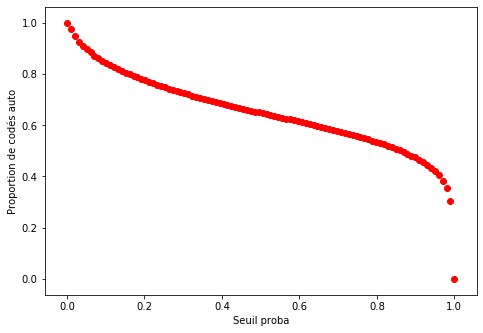

In [ ]:
# -----------------------------------------------------------------------
# SEUIL_CODAGE_AUTO_MODULABLE
# -----------------------------------------------------------------------

SEUIL_CODAGE_AUTO_MODULABLE = np.linspace(0, 1, num=100)

res = []
res_precision = []

for s in SEUIL_CODAGE_AUTO_MODULABLE:
    res.append((df_siretc_nona['siret_codage_auto_proba'] > s).mean())
    mask = (full_df['siret_codage_auto_proba'] > s) & (~full_df.siretm_AIEE.isna())
    res_precision.append((full_df.loc[mask,'topk_siret'] == 1).mean())
    
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(SEUIL_CODAGE_AUTO_MODULABLE, res, color='r')
ax.set_xlabel('Seuil proba')
ax.set_ylabel('Proportion de codés auto')
plt.show()

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(SEUIL_CODAGE_AUTO_MODULABLE, res_precision, color='r')
ax.set_xlabel('Seuil proba')
ax.set_ylabel('Précision')
plt.show()

mask2 = (~full_df.siretm_AIEE.isna())
full_df.loc[mask2,'siret_codage_auto_proba'].hist()
print(full_df.loc[mask2,'siret_codage_auto_proba'].quantile([i*.1 for i in range(1,10)]))

In [9]:
# -----------------------------------------------------------------------
# CALCUL DU TOP-K POUR L'ACTIVITE -- ALGO STARCLAY
# -----------------------------------------------------------------------
df_actetc_nona = full_df.copy()

print("="*80)
print("CALCUL DU TOP-K POUR L'ACTIVITE -- ALGO STARCLAY")
print("="*80)
print(' ')

df_actetc_nona['topk_naf'].value_counts().cumsum() / len(df_actetc_nona)

print("Prédiction de l'activité")
for k in range(1,11):
    topk = ((df_actetc_nona['topk_naf'] > 0) & (df_actetc_nona['topk_naf'] <= k)).sum()/len(df_actetc_nona)
    print('Top {} : {:.2f}'.format(k, topk))
    

CALCUL DU TOP-K POUR L'ACTIVITE -- ALGO STARCLAY
 
Prédiction de l'activité
Top 1 : 0.23
Top 2 : 0.40
Top 3 : 0.50
Top 4 : 0.55
Top 5 : 0.59
Top 6 : 0.62
Top 7 : 0.65
Top 8 : 0.67
Top 9 : 0.68
Top 10 : 0.69


In [10]:
# -----------------------------------------------------------------------
# CALCUL DU TOP-1 DE SICORE / MCA
# -----------------------------------------------------------------------

print("="*80)
print("CALCUL DU TOP-1 DE SICORE / MCA")
print("="*80)
print(' ')

df_siretc_nona['prediction_sicore_is_true'] = (df_siretc_nona['siret_dec'] == df_siretc_nona['siretc'])

print('Prediction SICORE')

print(" ")
print("="*80)
print("Ensemble de l'échantillon")
print('Taille echantillon : '+ str(len(df_siretc_nona)))

mask = df_siretc_nona['MCA_code_auto']
print('Proportion de codés auto par MCA : {:.2f}'.format(mask.mean()))
print('Top 1 -- complet : {:.2f}'.format(df_siretc_nona['prediction_sicore_is_true'].mean()))

print('Top 1 -- Mis en codage auto : {:.2f} \n'.format(df_siretc_nona.loc[mask, 'prediction_sicore_is_true'].mean()))

for dep in df_siretc_nona.dep_code.unique():
    print(" ")
    print("="*80)
    print('Departement : '+ dep)
    print('Taille echantillon : '+ str((df_siretc_nona['dep_code'] == dep).sum()))
    print('Top 1 -- complet : {:.2f}'.format(df_siretc_nona.loc[df_siretc_nona['dep_code'] == dep, 'prediction_sicore_is_true'].mean()))
    
    mask = (df_siretc_nona['MCA_code_auto']) & (df_siretc_nona['dep_code'] == dep)
    print('Top 1 -- Mis en codage auto : {:.2f} \n'.format(df_siretc_nona.loc[mask, 'prediction_sicore_is_true'].mean()))
    

CALCUL DU TOP-1 DE SICORE / MCA
 
Prediction SICORE
 
Ensemble de l'échantillon
Taille echantillon : 65740
Proportion de codés auto par MCA : 0.45
Top 1 -- complet : 0.58
Top 1 -- Mis en codage auto : 1.00 

 
Departement : 92
Taille echantillon : 17337
Top 1 -- complet : 0.62
Top 1 -- Mis en codage auto : 1.00 

 
Departement : 14
Taille echantillon : 12818
Top 1 -- complet : 0.60
Top 1 -- Mis en codage auto : 1.00 

 
Departement : 63
Taille echantillon : 14255
Top 1 -- complet : 0.61
Top 1 -- Mis en codage auto : 1.00 

 
Departement : 57
Taille echantillon : 21330
Top 1 -- complet : 0.50
Top 1 -- Mis en codage auto : 1.00 



In [11]:
# -----------------------------------------------------------------------
# COMPARAISON ALGO STARCLAY vs. MCA
# -----------------------------------------------------------------------

print("="*80)
print("COMPARAISON ALGO STARCLAY vs. MCA")
print("="*80)
print(' ')

# Regardons quand Starclay raison et SICORE a tort
mask = (df_siretc_nona['siret_dec'] != df_siretc_nona['siretc']) & (df_siretc_nona['topk_siret']==1)
print('Proportion des cas où algo Starclay a le bon SIRET, mais pas MCA : {:.2f}'.format(mask.mean()))

# Regardons quand Starclay a tort et SICORE raison
mask = (df_siretc_nona['siret_dec'] == df_siretc_nona['siretc']) & (df_siretc_nona['topk_siret']!=1)
print('Proportion des cas où algo Starclay a le mauvais SIRET, mais MCA trouve le bon : {:.2f}'.format(mask.mean()))

COMPARAISON ALGO STARCLAY vs. MCA
 
Proportion des cas où algo Starclay a le bon SIRET, mais pas MCA : 0.08
Proportion des cas où algo Starclay a le mauvais SIRET, mais MCA trouve le bon : 0.14


# CODES AUTO PAR MCA

In [12]:
# -----------------------------------------------------------------------
# CODES AUTO PAR MCA
# -----------------------------------------------------------------------

print("="*80)
print("CODES AUTO PAR MCA")
print("="*80)
print(' ')

# extraction du SIRET top-1 rpédit par Algo Starclay
with tqdm(total=len(df_siretc_nona)) as prog:
    for index, row in enumerate(df_siretc_nona.itertuples()):
        df_siretc_nona.at[index, 'siret_predictions_top1'] = row.siret_predictions[0][0]
        prog.update(1)


mask = df_siretc_nona['MCA_code_auto'] # On se limite aux codés auto par MCA
    
print('Parmi les bulletins codés auto par MCA, proportion de codés auto par Starclay: {:.2f}'.format((df_siretc_nona.loc[mask,'siret_codage_auto_proba'] > SEUIL_CODAGE_AUTO).mean()))

codes_auto_starclay_parmi_codes_auto_mca = mask & (df_siretc_nona['siret_codage_auto_proba'] > SEUIL_CODAGE_AUTO)
print('Parmi les bulletins codés auto par MCA, proportion de codés auto par Starclay avec le même SIRET: {:.2f}'.format((df_siretc_nona.loc[codes_auto_starclay_parmi_codes_auto_mca, 'siretc']==df_siretc_nona.loc[codes_auto_starclay_parmi_codes_auto_mca, 'siret_predictions_top1']).mean()))

  0%|          | 0/65740 [00:00<?, ?it/s]

CODES AUTO PAR MCA
 


100%|██████████| 65740/65740 [00:01<00:00, 64549.01it/s]

Parmi les bulletins codés auto par MCA, proportion de codés auto par Starclay: 0.74
Parmi les bulletins codés auto par MCA, proportion de codés auto par Starclay avec le même SIRET: 0.91


# CODES MANUELLEMENT PAR L'EQUIPE RP

In [37]:
# -----------------------------------------------------------------------
# CODES MANUELLEMENT
# -----------------------------------------------------------------------

print("="*80)
print("CODES MANUELLEMENT")
print("="*80)
print(' ')

mask = ~df_siretc_nona['MCA_code_auto'] # On se limite aux codés manuellement 

print('Parmi les bulletins codés manuellement, proportion de codés auto par Starclay: {:.2f}'.format((df_siretc_nona.loc[mask,'siret_codage_auto_proba'] > SEUIL_CODAGE_AUTO).mean()))
print('Parmi les bulletins codés manuellement, proportion de non-codable détectés par Starclay: {:.2f}'.format((df_siretc_nona.loc[mask,'non_codable_score'] > SEUIL_NON_CODABLE).mean()))

# codés manuellement par MCA et codés auto Starclay
mask2 = (~df_siretc_nona['MCA_code_auto']) & (df_siretc_nona['siret_codage_auto_proba'] > SEUIL_CODAGE_AUTO) # On se limite aux codés manuellement 
print('Parmi les bulletins codés manuellement et codés auto par Starclay, top-1 : {:.2f}'.format((df_siretc_nona.loc[mask2,'topk_siret']==1).mean()))

CODES MANUELLEMENT
 
Parmi les bulletins codés manuellement, proportion de codés auto par Starclay: 0.32
Parmi les bulletins codés manuellement, proportion de non-codable détectés par Starclay: 0.09
Parmi les bulletins codés manuellement et codés auto par Starclay, top-1 : 0.61


# PERFORMANCE DU SCORE NON-CODABLE

COURBE ROC POUR LE SCORE NON-CODABLE
 


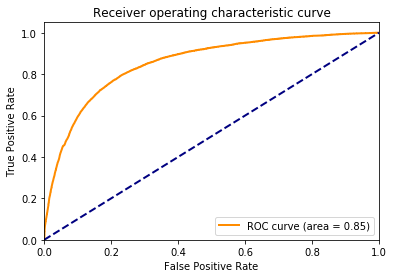

False    0.84428
True     0.15572
Name: non_codable, dtype: float64
PERFORMANCE DU SCORE NON-CODABLE
 
Seuil non codable : 0.85
Precision : 0.80
Rappel : 0.08


In [14]:
# -----------------------------------------------------------------------
# PERFORMANCE DU SCORE NON-CODABLE
# -----------------------------------------------------------------------

print("="*80)
print("COURBE ROC POUR LE SCORE NON-CODABLE")
print("="*80)
print(' ')

full_df['non_codable'] = full_df['siret_dec'].isna()
#& full_df['actet_c'].isna()
df_test = full_df.dropna(subset=['non_codable_score'])

y = label_binarize(df_test['non_codable'], classes=[0, 1])
n_classes = y.shape[1]

y_score = df_test["non_codable_score"]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

# Proportion de positifs/negatifs dans le jeu de données
print(full_df['non_codable'].value_counts()/len(full_df))

print("="*80)
print("PERFORMANCE DU SCORE NON-CODABLE")
print("="*80)
print(' ')
# Calcul de précision/rappel
SEUIL_NON_CODABLE = .85
df_test['y_hat'] = (df_test['non_codable_score']>SEUIL_NON_CODABLE)
print('Seuil non codable : {}'.format(SEUIL_NON_CODABLE))
print('Precision : {:.2f}'.format(df_test.loc[df_test['y_hat'], 'non_codable'].mean()))
print('Rappel : {:.2f}'.format(df_test.loc[df_test['non_codable'], 'y_hat'].mean()))

In [15]:
# -----------------------------------------------------------------------
# COLLECTE DANS LA BASE
# -----------------------------------------------------------------------

print("="*80)
print("INFLUENCE DE L'ALGO SUR LE CHOIX DU GESTIONNAIRE")
print("="*80)
print(' ')


champs = ['cabbi', 'siretm', 'open', 'close_act']
requete = """SELECT a.cabbi,
                    a.siretm,
                    b.open,
                    b.close_act
            FROM rp.individus AS a LEFT JOIN rp.app_log_bi AS b on a.cabbi = b.cabbi
            WHERE a.i_reprise_act = 'V'"""
connection=pg_connect(pg_param_dic)
df_reprise_aiee = postgresql_to_dataframe(connection, requete, list(champs))

df_reprise_aiee.rename(columns={'siretm': 'siretm_AIEE'}, inplace=True)
full_df = pd.merge(full_df, df_reprise_aiee, on="cabbi", how="left")

full_df['duration'] = pd.to_datetime(full_df['close_act']) - pd.to_datetime(full_df['open'])
full_df['week'] = full_df['close_act'].dt.week
full_df.head()

INFLUENCE DE L'ALGO SUR LE CHOIX DU GESTIONNAIRE
 
Connecting to the PostgreSQL database...
Connection successful


,cabbi,siret_predictions,siret_codage_auto_proba,naf_predictions,non_codable_score,com_code,dep_code,clt_c_c,siretc,siretm,...,topk_siret_reranked,topk_siret_OLD,topk_naf_OLD,topk_siret_reranked_OLD,non_codable,siretm_AIEE,open,close_act,duration,week
0,0353683388,"[[22320001500178, 1.6045883748714045], [223200...",0.650909,"[[8411, 1.0640380015566555], [8411Z, 1.0235906...",0.003703,022,92,32013,48165981100030,None,...,-1.0,-1.0,-1.0,-1.0,False,NaN,NaT,NaT,NaT,NaN
1,0353626321,"[[57202804100430, 3.2811161198256333], [434209...",0.999646,"[[6920, 1.1254562292934496], [6920Z, 1.0815629...",0.009035,026,92,92062,57202804100430,None,...,1.0,1.0,2.0,1.0,False,57202804100430,2021-07-05 13:07:42.721704,2021-07-05 13:08:05.707358,00:00:22.985654,27.0
2,0353852428,"[[57202804100430, 2.175019541146966], [4019482...",0.997572,"[[6920Z, 1.1005842580148864], [6920, 1.0905856...",0.211551,033,92,92LDF,57202804100430,None,...,1.0,1.0,1.0,1.0,False,43420979700027,2021-07-08 09:06:12.580581,2021-07-08 09:06:55.645129,00:00:43.064548,27.0
3,0353932115,"[[31422290200046, 3.197940995394589], [4375744...",0.990655,"[[6619B, 1.432938720995901], [6630, 1.36380273...",0.001958,071,92,75115,31422290200046,None,...,1.0,1.0,7.0,1.0,False,31422290200046,2021-07-06 08:57:35.471021,2021-07-06 08:58:02.420392,00:00:26.949371,27.0
4,0353738676,"[[38149973000012, 2.344574567549764], [3282534...",0.996537,"[[4779Z, 0.9220594732733282], [4789Z, 0.871548...",0.027650,062,92,93070,38149973000012,None,...,1.0,1.0,1.0,1.0,False,38149973000012,2021-06-24 11:22:18.198853,2021-06-24 11:22:49.819127,00:00:31.620274,25.0


In [16]:
# -----------------------------------------------------------------------
# CALCUL DE L'ALGO STARCLAY PAR RAPPORT A LA NOUVELLE LABELLISATION
# -----------------------------------------------------------------------

print("="*80)
print("CALCUL DE L'ALGO STARCLAY PAR RAPPORT A LA NOUVELLE LABELLISATION")
print("="*80)
print(' ')

print(f"temps moyen par bulletin : {full_df['duration'].mean()}")
print(f"temps moyen par bulletin, à l'exclusion des 5% les plus longs : {full_df.loc[full_df['duration'] < full_df['duration'].quantile(.95), 'duration'].mean()}")


with tqdm(total=len(full_df)) as prog:
    for index, row in enumerate(full_df.itertuples()):
        full_df.at[index, 'topk_siret'] = isInTopK(target=row.siretm_AIEE, topKList=row.siret_predictions)
        full_df.at[index, 'topk_siret_reranked'] = rerankByCity(target=row.siretm_AIEE, targetCity=row.clt_c_c, topKList=row.siret_predictions, connection=connection)
        prog.update(1)
        
mask = (~full_df.siretm_AIEE.isna())
mask_code_auto = (~full_df.siretm_AIEE.isna()) & (df_siretc_nona['siret_codage_auto_proba'] > SEUIL_CODAGE_AUTO) & (df_siretc_nona['non_codable_score']<SEUIL_NON_CODABLE)

for k in range(1,11):
    topk = ((full_df.loc[mask,'topk_siret'] > 0) & (full_df.loc[mask,'topk_siret'] <= k)).sum()/mask.sum()
    print('Top {} -- toute prédiction : {:.2f}'.format(k, topk))
    topk = ((full_df.loc[mask_code_auto,'topk_siret'] > 0) & (full_df.loc[mask_code_auto,'topk_siret'] <= k)).sum()/mask_code_auto.sum()
    print('Top {} --- sur les mis en codage auto : {:.2f}'.format(k, topk))
    
    topk = ((full_df.loc[mask,'topk_siret_reranked'] > 0) & (full_df.loc[mask,'topk_siret_reranked'] <= k)).sum()/mask.sum()
    print('Top {} ré-arrangé --- toute prédiction : {:.2f}'.format(k, topk))
    topk = ((full_df.loc[mask_code_auto,'topk_siret_reranked'] > 0) & (full_df.loc[mask_code_auto,'topk_siret_reranked'] <= k)).sum()/mask_code_auto.sum()
    print('Top {} ré-arrangé --- sur les mis en codage auto : {:.2f}'.format(k, topk))
    
    print(' ')
    print("="*80)

  0%|          | 20/65740 [00:00<05:42, 191.79it/s]

CALCUL DE L'ALGO STARCLAY PAR RAPPORT A LA NOUVELLE LABELLISATION
 
temps moyen par bulletin : 0 days 01:04:15.875716
temps moyen par bulletin, à l'exclusion des 5% les plus longs : 0 days 00:01:07.940567


100%|██████████| 65740/65740 [05:09<00:00, 212.59it/s]


Top 1 -- toute prédiction : 0.57
Top 1 --- sur les mis en codage auto : 0.81
Top 1 ré-arrangé --- toute prédiction : 0.59
Top 1 ré-arrangé --- sur les mis en codage auto : 0.81
 
Top 2 -- toute prédiction : 0.64
Top 2 --- sur les mis en codage auto : 0.87
Top 2 ré-arrangé --- toute prédiction : 0.66
Top 2 ré-arrangé --- sur les mis en codage auto : 0.87
 
Top 3 -- toute prédiction : 0.68
Top 3 --- sur les mis en codage auto : 0.89
Top 3 ré-arrangé --- toute prédiction : 0.69
Top 3 ré-arrangé --- sur les mis en codage auto : 0.89
 
Top 4 -- toute prédiction : 0.69
Top 4 --- sur les mis en codage auto : 0.89
Top 4 ré-arrangé --- toute prédiction : 0.71
Top 4 ré-arrangé --- sur les mis en codage auto : 0.90
 
Top 5 -- toute prédiction : 0.71
Top 5 --- sur les mis en codage auto : 0.90
Top 5 ré-arrangé --- toute prédiction : 0.72
Top 5 ré-arrangé --- sur les mis en codage auto : 0.90
 
Top 6 -- toute prédiction : 0.72
Top 6 --- sur les mis en codage auto : 0.90
Top 6 ré-arrangé --- toute p

In [54]:
# temps passé sur le codage des BI considérés comme non codables automatiquement par Starclay.

mask = (full_df['siret_codage_auto_proba'] < SEUIL_CODAGE_AUTO) & (full_df['duration'] < full_df['duration'].quantile(.95))
print((full_df.loc[mask,'duration']).mean())

0 days 00:01:26.903809


In [41]:
# codés manuellement par MCA et codés auto Starclay
mask2 = (~full_df['MCA_code_auto']) & (full_df['siret_codage_auto_proba'] > SEUIL_CODAGE_AUTO) & (~full_df.siretm_AIEE.isna()) & (full_df['non_codable_score']<SEUIL_NON_CODABLE) # On se limite aux codés manuellement 
print('Parmi les bulletins codés manuellement et codés auto par Starclay, top-1 : {:.2f}'.format((full_df.loc[mask2,'topk_siret']==1).mean()))

Parmi les bulletins codés manuellement et codés auto par Starclay, top-1 : 0.71


In [19]:
print("="*80)
print("RESULTATS PAR SEMAINE")
print("="*80)
print(' ')

week_list = sorted([i for i in full_df.week.unique()])
week_list.pop(0)
week_list = sorted([int(i) for i in week_list])

topk_by_week = {}

for k in range(1,11):
    topk_by_week[k] = []
    for week in week_list:
        print(f"SEMAINE {week}")
        mask_week = (full_df['week'] == week)
        full_mask =  (mask & mask_week)
        full_mask_code_auto = (mask_code_auto & mask_week)
    
        topk = ((full_df.loc[full_mask,'topk_siret'] > 0) & (full_df.loc[full_mask,'topk_siret'] <= k)).sum()/full_mask.sum()
        print('    Top {} -- toute prédiction : {:.2f}'.format(k, topk))
        topk = ((full_df.loc[full_mask,'topk_siret_reranked'] > 0) & (full_df.loc[full_mask,'topk_siret_reranked'] <= k)).sum()/full_mask.sum()
        print('    Top {} ré-arrangé --- toute prédiction : {:.2f}'.format(k, topk))
        
        topk_by_week[k].append(topk)
    print(' ')
    print("="*80)

RESULTATS PAR SEMAINE
 
SEMAINE 19
    Top 1 -- toute prédiction : 1.00
    Top 1 ré-arrangé --- toute prédiction : 1.00
SEMAINE 20
    Top 1 -- toute prédiction : 0.49
    Top 1 ré-arrangé --- toute prédiction : 0.52
SEMAINE 21
    Top 1 -- toute prédiction : 0.49
    Top 1 ré-arrangé --- toute prédiction : 0.53
SEMAINE 22
    Top 1 -- toute prédiction : 0.51
    Top 1 ré-arrangé --- toute prédiction : 0.57
SEMAINE 23
    Top 1 -- toute prédiction : 0.49
    Top 1 ré-arrangé --- toute prédiction : 0.54
SEMAINE 24
    Top 1 -- toute prédiction : 0.54
    Top 1 ré-arrangé --- toute prédiction : 0.55
SEMAINE 25
    Top 1 -- toute prédiction : 0.55
    Top 1 ré-arrangé --- toute prédiction : 0.56
SEMAINE 26
    Top 1 -- toute prédiction : 0.60
    Top 1 ré-arrangé --- toute prédiction : 0.61
SEMAINE 27
    Top 1 -- toute prédiction : 0.63
    Top 1 ré-arrangé --- toute prédiction : 0.64
SEMAINE 28
    Top 1 -- toute prédiction : 0.60
    Top 1 ré-arrangé --- toute prédiction : 0.61
SEMAIN

In [34]:
print("="*80)
print("PLOT TOP 1, 5 AND 10 BY WEEK")
print("="*80)
print(' ')

plt.figure()
plt.plot(week_list[1:-1], topk_by_week[1][1:-1], 'b',
        label='Top 1')
plt.plot(week_list[1:-1], topk_by_week[5][1:-1], 'r',
        label='Top 5')
plt.plot(week_list[1:-1], topk_by_week[10][1:-1], 'g',
        label='Top 10')
plt.xlabel('Week')
plt.axis([20, 28, 0, 1])
plt.legend(loc="lower right")
plt.savefig('topk_by_week.pdf', dpi=(96))
plt.close()

PLOT TOP 1, 5 AND 10 BY WEEK
 


In [21]:
# -----------------------------------------------------------------------
# CALCUL DE MCA PAR RAPPORT A LA NOUVELLE LABELLISATION
# -----------------------------------------------------------------------

print("="*80)
print("CALCUL DE MCA PAR RAPPORT A LA NOUVELLE LABELLISATION")
print("="*80)
print(' ')

mask = (~full_df.siretm_AIEE.isna())

print('Précision MCA : {:.2f} \n'.format((full_df.loc[mask, 'siretm_AIEE'] == full_df.loc[mask, 'siretc'] ).mean()))

CALCUL DE MCA PAR RAPPORT A LA NOUVELLE LABELLISATION
 
Précision MCA : 0.49 



In [22]:
# -----------------------------------------------------------------------
# INFLUENCE DE L'ALGO SUR LE CHOIX DU GESTIONNAIRE
# -----------------------------------------------------------------------

mask = (~full_df.siretm_AIEE.isna()) & (~full_df.siretm.isna())
print('Proportion de bulletins qui ne sont pas (encore) passés devant les gestionnaires : {:.2f}'.format(mask.mean()))

print('Proportion des bulletins où les gestionnaires ne codent pas de la même manière selon MCA ou Algo Starclay : {:.2f}'.format((full_df.loc[mask, 'siretm_AIEE'] != full_df.loc[mask, 'siretm']).mean()))


# On regarde si le SIRET choisi est dans les echos proposés
with tqdm(total=len(full_df)) as prog:
    for index, row in enumerate(full_df.itertuples()):
        full_df.at[index, 'topk_siret_m_AIEE'] = isInTopK(target=row.siretm_AIEE, topKList=row.siret_predictions)
        prog.update(1)
        
df_siretmAIEE_nona = full_df.dropna(subset=['siretm_AIEE'])
#mask = ~(df_siretmAIEE_nona.siretm_AIEE.str.strip()=='')

for k in range(1,11):
    topk = ((df_siretmAIEE_nona['topk_siret_m_AIEE'] > 0) & (df_siretmAIEE_nona['topk_siret_m_AIEE'] <= k)).sum()/len(df_siretmAIEE_nona)
    print('Parmi les codés, le SIRET choisi par le gestionnaire était dans le top {} : {:.2f}'.format(k, topk))


print('Le BI a été codé à blanc : {:.2f}'.format((df_siretmAIEE_nona['siretm_AIEE'].str.strip()=='').mean()))

  0%|          | 1/65740 [00:00<2:25:49,  7.51it/s]

Proportion de bulletins qui ne sont pas (encore) passés devant les gestionnaires : 0.29
Proportion des bulletins où les gestionnaires ne codent pas de la même manière selon MCA ou Algo Starclay : 0.37


100%|██████████| 65740/65740 [00:02<00:00, 23201.42it/s]


Parmi les codés, le SIRET choisi par le gestionnaire était dans le top 1 : 0.57
Parmi les codés, le SIRET choisi par le gestionnaire était dans le top 2 : 0.64
Parmi les codés, le SIRET choisi par le gestionnaire était dans le top 3 : 0.68
Parmi les codés, le SIRET choisi par le gestionnaire était dans le top 4 : 0.69
Parmi les codés, le SIRET choisi par le gestionnaire était dans le top 5 : 0.71
Parmi les codés, le SIRET choisi par le gestionnaire était dans le top 6 : 0.72
Parmi les codés, le SIRET choisi par le gestionnaire était dans le top 7 : 0.72
Parmi les codés, le SIRET choisi par le gestionnaire était dans le top 8 : 0.73
Parmi les codés, le SIRET choisi par le gestionnaire était dans le top 9 : 0.74
Parmi les codés, le SIRET choisi par le gestionnaire était dans le top 10 : 0.74
Le BI a été codé à blanc : 0.14


In [23]:
# -----------------------------------------------------------------------
# DECOMPTE FINAL
# -----------------------------------------------------------------------

print('Proportion de bulletins non codables : {:.3f}'.format(full_df['non_codable'].mean()))

print("="*80)
print("ALGO STARCLAY")
print("="*80)
print(' ')

SEUIL_NON_CODABLE = .5
SEUIL_CODAGE = .3

full_df['y_hat'] = (full_df['non_codable_score']>SEUIL_NON_CODABLE)
print('Proportion de bulletins non codables selon Algo Starclay: {:.3f}'.format(full_df['y_hat'].mean()))

mask = (~full_df['y_hat']) & (full_df['siret_codage_auto_proba'] > SEUIL_CODAGE) # BI considéré codable et en codage auto
print('Proportion de bulletins codés auto sur le total selon Algo Starclay: {:.3f}'.format(mask.mean()))

topk = ((full_df.loc[mask,'topk_siret'] > 0) & (full_df.loc[mask,'topk_siret'] <= 1)).mean()
print('Précision sur le top-1 en codage auto, selon Starclay : {:.3f}'.format(topk))

#print('Proportion totale de bulletins automatisés : {}'.format())

print("="*80)
print("ALGO SICORE")
print("="*80)
print(' ')

print('Proportion de bulletins non codables selon MCA : NA')

mask = full_df['MCA_code_auto'] # BI considéré codable et en codage auto
print('Proportion de bulletins codés auto sur le total selon MCA: {:.3f}'.format(mask.mean()))

topk = ((full_df.loc[mask,'topk_siret'] > 0) & (full_df.loc[mask,'topk_siret'] <= 1)).mean()
print('Précision sur le top-1 en codage auto, selon MCA : {:.3f}'.format(topk))


Proportion de bulletins non codables : 0.156
ALGO STARCLAY
 
Proportion de bulletins non codables selon Algo Starclay: 0.057
Proportion de bulletins codés auto sur le total selon Algo Starclay: 0.703
Précision sur le top-1 en codage auto, selon Starclay : 0.518
ALGO SICORE
 
Proportion de bulletins non codables selon MCA : NA
Proportion de bulletins codés auto sur le total selon MCA: 0.446
Précision sur le top-1 en codage auto, selon MCA : 0.572
